In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
fraud_data = pd.read_csv('../data/cleaned_data_1.csv')
credit_data = pd.read_csv('../data/cleaned_data_2.csv')

In [3]:
# Drop non-numeric columns that are not needed for model training
fraud_data = fraud_data.drop(["user_id", "device_id", "signup_time", "purchase_time"], axis=1)



In [4]:
# Define features and target variable
X = fraud_data.drop("class", axis=1)
y = fraud_data["class"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9581202736766294
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     25193
           1       1.00      0.55      0.71      2577

    accuracy                           0.96     27770
   macro avg       0.98      0.77      0.84     27770
weighted avg       0.96      0.96      0.95     27770



## Analyze Feature Importance

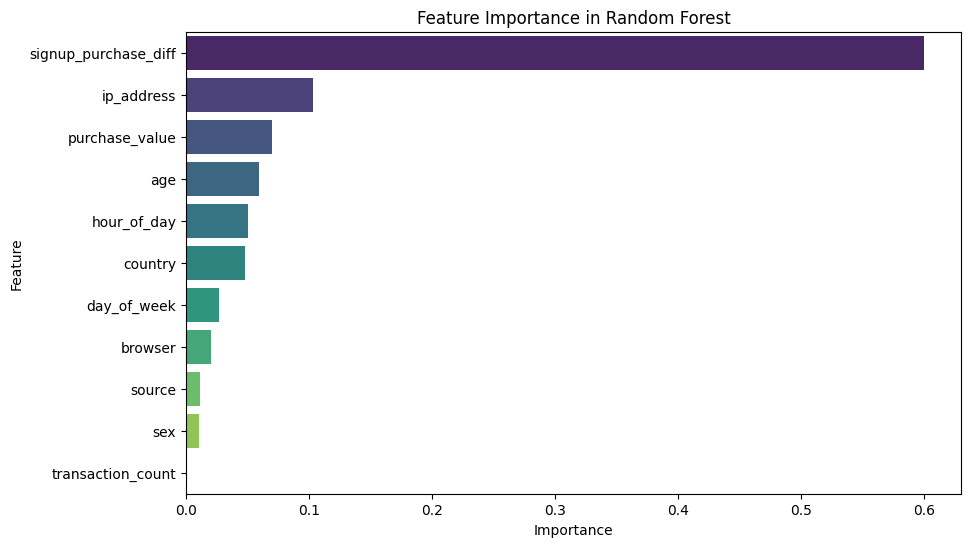

In [6]:
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, hue="Feature", palette="viridis", legend=False)
plt.title("Feature Importance in Random Forest")
plt.show()


# Use SHAP for Model Explainability

In [7]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test[:100], check_additivity=False)




 96%|=================== | 192/200 [00:24<00:01]       

In [20]:
# Convert X_test to DataFrame with proper column names and use only first 100 samples
X_test_sample = pd.DataFrame(X_test[:100], columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [21]:
print(type(shap_values))
print(shap_values.shape)  # Check if this is a 2D array (samples, features)


<class 'shap._explanation.Explanation'>
(100, 11, 2)


In [22]:
feature_index = X_test.columns.get_loc("purchase_value")


In [23]:
print(shap_values[:, feature_index, 0].shape)  # For class 0
print(shap_values[:, feature_index, 1].shape)  # For class 1


(100,)
(100,)


In [24]:
print(X_test.shape)


(27770, 11)


In [34]:
# Extract SHAP values for each class as numpy arrays
shap_values_class_0 = shap_values[:, :, 0].values  # SHAP values for class 0 (legitimate)
shap_values_class_1 = shap_values[:, :, 1].values  # SHAP values for class 1 (fraud)

In [26]:
print(shap_values_class_0.shape)


(100, 11)


<Figure size 1000x600 with 0 Axes>

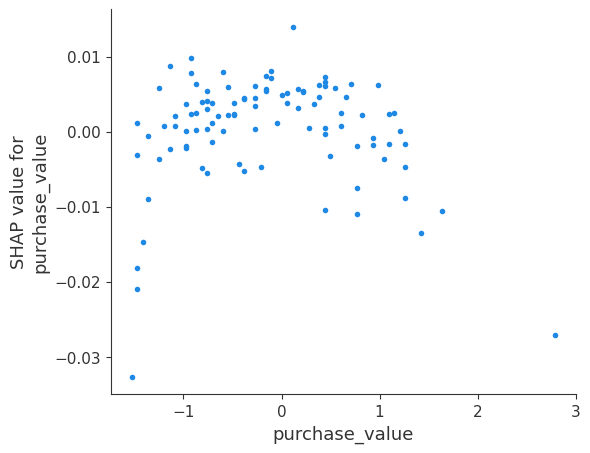

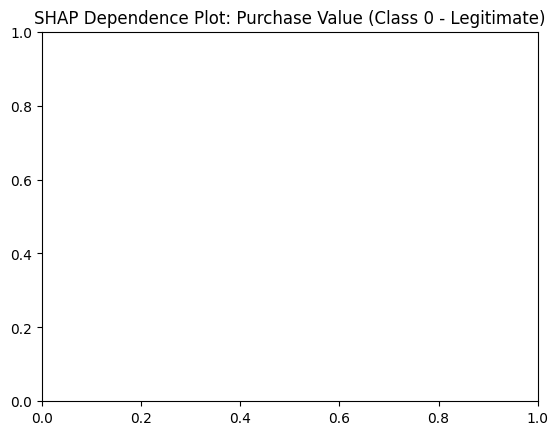

In [35]:
# Dependence Plot - Shows how a single feature affects predictions
plt.figure(figsize=(10, 6))
shap.dependence_plot(feature_index, shap_values_class_0, X_test_sample, interaction_index=None)
plt.title("SHAP Dependence Plot: Purchase Value (Class 0 - Legitimate)")
plt.show()

## SHAP Summary Plots - Overall Feature Impact

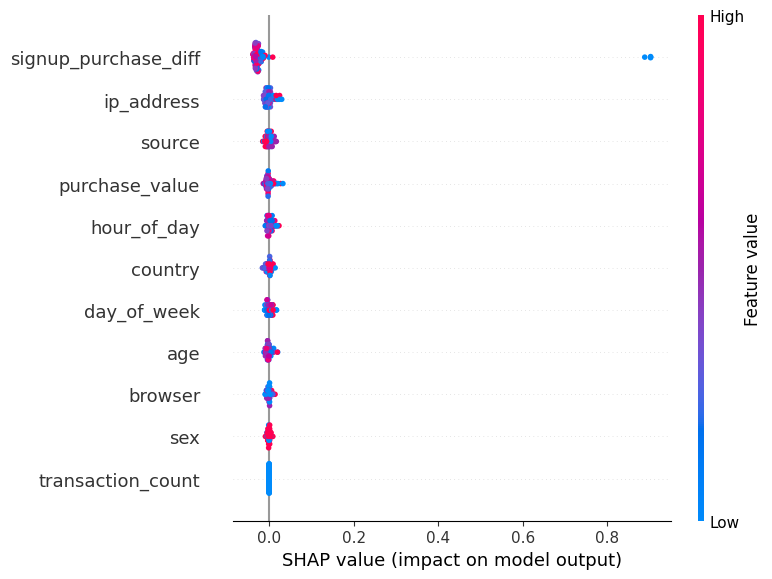

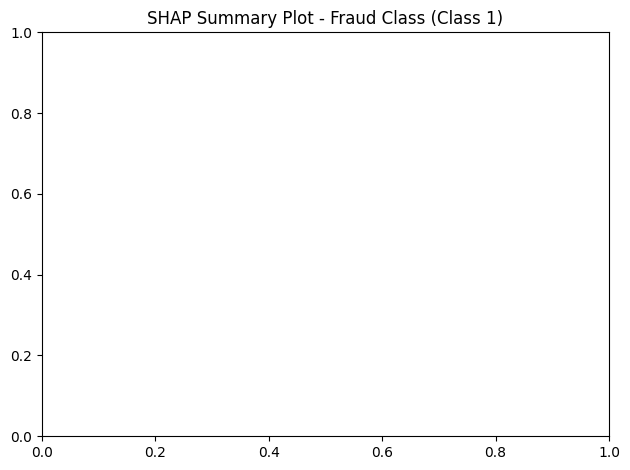

In [36]:
# SHAP Summary Plot - Bee swarm plot showing feature importance and impact
# Shows both the importance and the effect direction for fraud class
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class_1, X_test_sample, plot_type="dot", max_display=15)
plt.title("SHAP Summary Plot - Fraud Class (Class 1)")
plt.tight_layout()
plt.show()

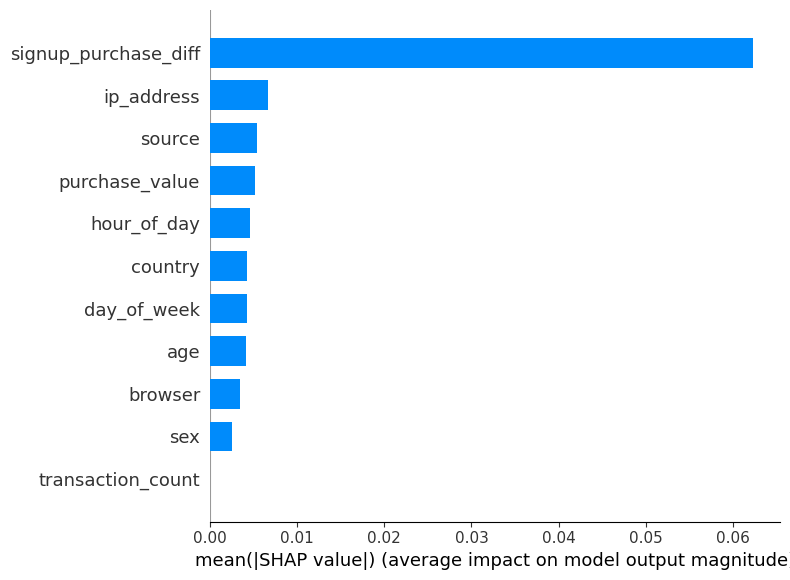

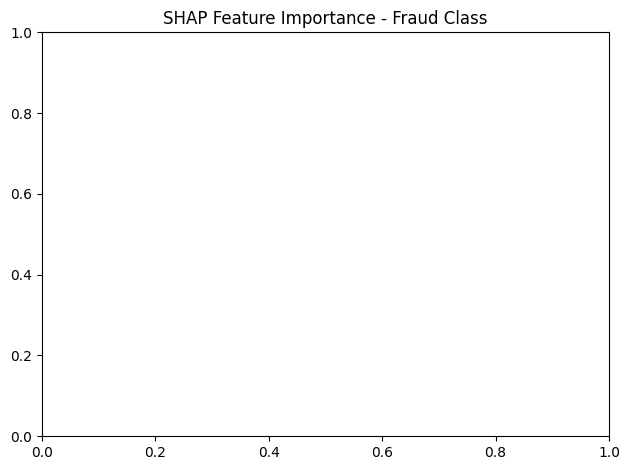

In [37]:
# SHAP Bar Plot - Feature importance by mean absolute SHAP value
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class_1, X_test_sample, plot_type="bar", max_display=15)
plt.title("SHAP Feature Importance - Fraud Class")
plt.tight_layout()
plt.show()

## SHAP Waterfall Plot - Individual Prediction Explanation

Explaining prediction for sample 8 (Actual class: 1)
Predicted probability of fraud: 0.040
Predicted probability of fraud: 0.040


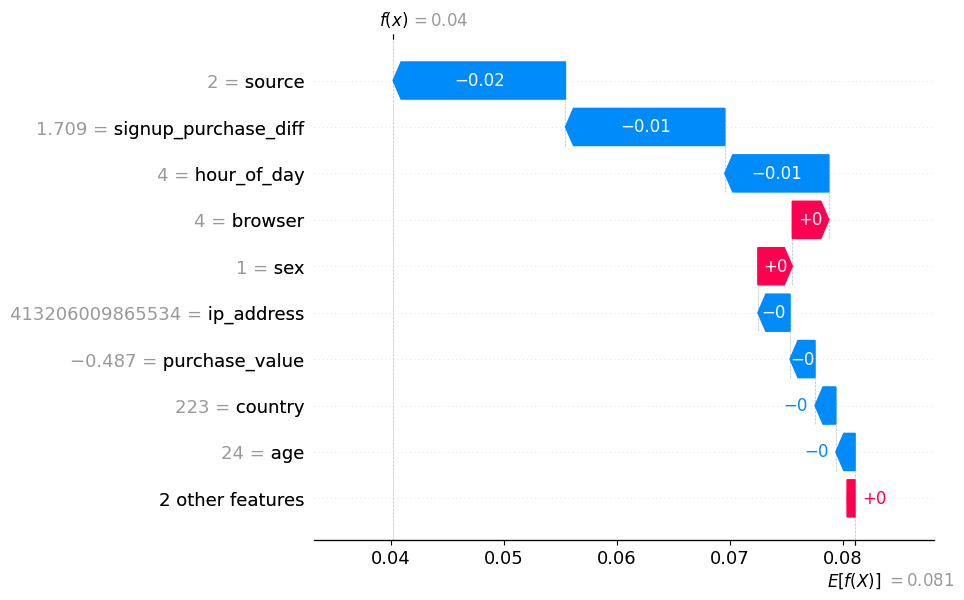

In [38]:
# Waterfall plot for the first prediction (shows how features push prediction up or down)
# Select a fraud case for detailed explanation
fraud_indices = [i for i in range(len(y_test[:100])) if y_test.iloc[i] == 1]
if fraud_indices:
    fraud_idx = fraud_indices[0]
    print(f"Explaining prediction for sample {fraud_idx} (Actual class: {y_test.iloc[fraud_idx]})")
    print(f"Predicted probability of fraud: {rf_model.predict_proba(X_test_sample.iloc[fraud_idx:fraud_idx+1])[0][1]:.3f}")
    shap.plots.waterfall(shap_values[fraud_idx, :, 1])
else:
    print("No fraud cases in the first 100 samples")
    shap.plots.waterfall(shap_values[0, :, 1])

## Key Insights from SHAP Analysis

**SHAP (SHapley Additive exPlanations) helps us understand:**

1. **Feature Importance**: Which features contribute most to fraud predictions
2. **Feature Effects**: How each feature value pushes predictions toward fraud or legitimate
3. **Feature Interactions**: How features work together (shown in dependence plots)
4. **Individual Predictions**: Why a specific transaction was classified as fraud

**Color coding in SHAP plots:**
- **Red**: High feature values
- **Blue**: Low feature values
- **Positive SHAP values**: Push prediction toward fraud (class 1)
- **Negative SHAP values**: Push prediction toward legitimate (class 0)

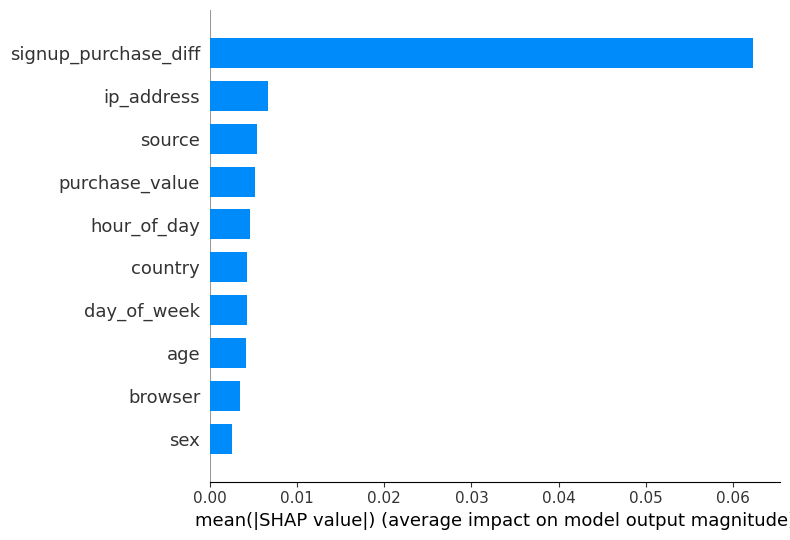

In [39]:
# Summary Plot - Shows the importance and impact of each feature
# Using the already extracted SHAP values for class 1 (fraud)
shap.summary_plot(shap_values_class_1, X_test_sample, plot_type="bar", max_display=10)

In [32]:
print(X_test.columns)


Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'ip_address',
       'country', 'signup_purchase_diff', 'transaction_count', 'day_of_week',
       'hour_of_day'],
      dtype='object')


In [40]:
# Force plot for the first sample - shows how features contribute to the prediction
# Using class 1 (fraud) for visualization
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1].values, X_test_sample.iloc[0, :])